In [288]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your CSV file
csv_file = 'Dataset/trajectories/10.csv'

# Read the CSV into a pandas DataFrame
df = pd.read_csv(csv_file)

# Specify the Track ID you want to filter
desired_track_id = 16

# Filter the DataFrame for the desired Track ID
filtered_df = df[df['Track ID'] == desired_track_id]

# Reset the index for the filtered DataFrame
filtered_df = filtered_df.reset_index(drop=True)

In [201]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from kalmanfilter import KalmanFilter

In [242]:
filtered_df['Kalman Filter Prediction X'] = np.nan
filtered_df['Kalman Filter Prediction Y'] = np.nan
filtered_df['Polynomial Regression X'] = np.nan
filtered_df['Polynomial Regression Y'] = np.nan

In [243]:
kf = KalmanFilter()

In [244]:
# Initialize the Kalman filter with the first measurement
first_x = filtered_df.at[0, 'Center X']
first_y = filtered_df.at[0, 'Center Y']
kf.kf.statePre = np.array([[np.float32(first_x)], [np.float32(first_y)], [0], [0]], np.float32)  # Initial state with velocity set to 0

# Store the first prediction for Kalman filter
filtered_df.at[0, 'Kalman Filter Prediction X'] = first_x
filtered_df.at[0, 'Kalman Filter Prediction Y'] = first_y


In [245]:
filtered_df.at[0, 'Polynomial Regression X'] = filtered_df.at[0, 'Center X']
filtered_df.at[0, 'Polynomial Regression Y'] = filtered_df.at[0, 'Center Y']

filtered_df.at[1, 'Polynomial Regression X'] = filtered_df.at[1, 'Center X']
filtered_df.at[1, 'Polynomial Regression Y'] = filtered_df.at[1, 'Center Y']


poly = PolynomialFeatures(degree=2)
lin_reg = LinearRegression()


In [246]:
# Loop through the filtered DataFrame to predict the next positions
for i in range(len(filtered_df) - 1):
    coordX = filtered_df.at[i, 'Center X']
    coordY = filtered_df.at[i, 'Center Y']

    # Kalman filter prediction
    predX_kf, predY_kf = kf.predict(coordX, coordY)
    filtered_df.at[i + 1, 'Kalman Filter Prediction X'] = predX_kf
    filtered_df.at[i + 1, 'Kalman Filter Prediction Y'] = predY_kf

    # Polynomial regression prediction
    if i >= 1:  # Now allows using the first two coordinates
        poly_X = poly.fit_transform(np.arange(i + 1).reshape(-1, 1))
        lin_reg.fit(poly_X, filtered_df['Center X'][:i + 1])
        next_point = poly.fit_transform([[i + 1]])
        filtered_df.at[i + 1, 'Polynomial Regression X'] = lin_reg.predict(next_point)[0]
        
        lin_reg.fit(poly_X, filtered_df['Center Y'][:i + 1])
        filtered_df.at[i + 1, 'Polynomial Regression Y'] = lin_reg.predict(next_point)[0]

# Extract original and predicted coordinates for plotting
x_coords = filtered_df['Center X']
y_coords = filtered_df['Center Y']
predicted_x_kf = filtered_df['Kalman Filter Prediction X']
predicted_y_kf = filtered_df['Kalman Filter Prediction Y']
predicted_x_poly = filtered_df['Polynomial Regression X']
predicted_y_poly = filtered_df['Polynomial Regression Y']

In [247]:
filtered_df['Error_Kalman_X'] = filtered_df['Kalman Filter Prediction X'] - filtered_df['Center X']
filtered_df['Error_Kalman_Y'] = filtered_df['Kalman Filter Prediction Y'] - filtered_df['Center Y']
filtered_df['Error_Regression_X'] = filtered_df['Polynomial Regression X'] - filtered_df['Center X']
filtered_df['Error_Regression_Y'] = filtered_df['Polynomial Regression Y']- filtered_df['Center Y']

In [248]:
filtered_df

,Track ID,Frame,Center X,Center Y,Mask Area,Kalman Filter Prediction X,Kalman Filter Prediction Y,Polynomial Regression X,Polynomial Regression Y,Error_Kalman_X,Error_Kalman_Y,Error_Regression_X,Error_Regression_Y
0,5,1,527,170,2505,527.0,170.0,527.000000,170.000000,0.0,0.0,0.000000,0.000000
1,5,2,531,171,2664,527.0,170.0,531.000000,171.000000,-4.0,-1.0,0.000000,0.000000
2,5,3,526,170,2530,529.0,170.0,539.000000,173.000000,3.0,0.0,13.000000,3.000000
3,5,4,525,171,2439,526.0,170.0,512.000000,167.000000,1.0,-1.0,-13.000000,-4.000000
4,5,5,528,170,2448,523.0,171.0,518.250000,171.000000,-5.0,1.0,-9.750000,1.000000
5,5,6,529,170,2476,527.0,170.0,527.200000,169.400000,-2.0,0.0,-1.800000,-0.600000
6,5,7,528,172,2411,529.0,169.0,530.500000,169.300000,1.0,-3.0,2.500000,-2.700000
7,5,8,524,175,2609,528.0,172.0,529.714286,172.000000,4.0,-3.0,5.714286,-3.000000
8,5,9,548,162,2657,523.0,176.0,524.714286,176.160714,-25.0,14.0,-23.285714,14.160714
9,5,10,544,169,2534,552.0,160.0,546.880952,164.428571,8.0,-9.0,2.880952,-4.571429


In [209]:
def calculate_rmse(group, error_column):
    N = len(group)  # Total number of observations in the group
    return np.sqrt(np.sum(group[error_column] ** 2) / N)

In [249]:
rmse_per_track = filtered_df.groupby('Track ID').apply(lambda group: pd.Series({
    'RMSE_Kalman_Y': calculate_rmse(group, 'Error_Kalman_Y'),
    'RMSE_Kalman_X': calculate_rmse(group,'Error_Kalman_X'),
    'RMSE_Regression_X': calculate_rmse(group, 'Error_Regression_X'),
    'RMSE_Regression_Y': calculate_rmse(group, 'Error_Regression_Y')
}))

In [250]:
rmse_per_track

,RMSE_Kalman_Y,RMSE_Kalman_X,RMSE_Regression_X,RMSE_Regression_Y
Track ID,,,,
5,10.25508,23.792506,25.136863,10.043568


In [251]:
import os
folder_path = 'Dataset/trajectorypredictions'
os.makedirs(folder_path, exist_ok=True)

filtered_df.to_csv(os.path.join(folder_path, '1_predictions_ID5.csv'))

### Visual Representations

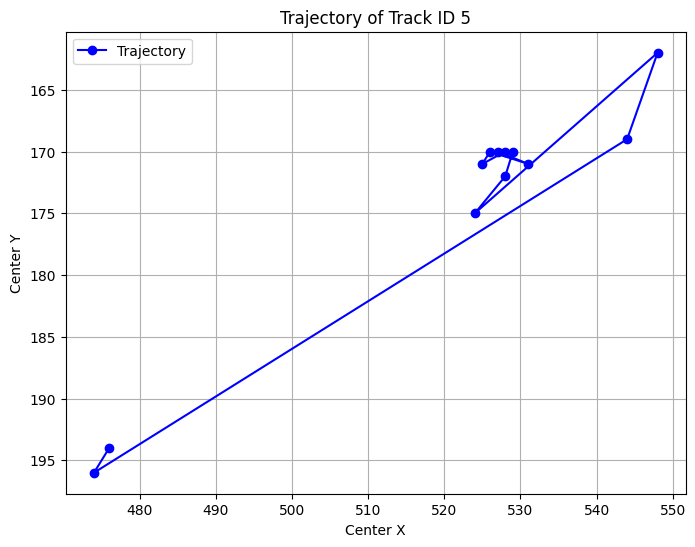

In [252]:
x_coords = filtered_df['Center X']
y_coords = filtered_df['Center Y']


highlight_start = 450
highlight_end = 780

highlight_start1= 1250
highlight_start2 = 1360

plt.figure(figsize=(8, 6))


plt.plot(x_coords, y_coords, marker='o', color='b', label='Trajectory')
#plt.axvspan(highlight_start, highlight_end, color='lightcoral', alpha=0.5)
#plt.axvspan(highlight_start1, highlight_start2, color='lightcoral', alpha=0.5)



# Invert the y-axis
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Center X')
plt.ylabel('Center Y')
plt.title(f'Trajectory of Track ID {desired_track_id}')
plt.legend()

# Show the plot
plt.grid()
plt.show()

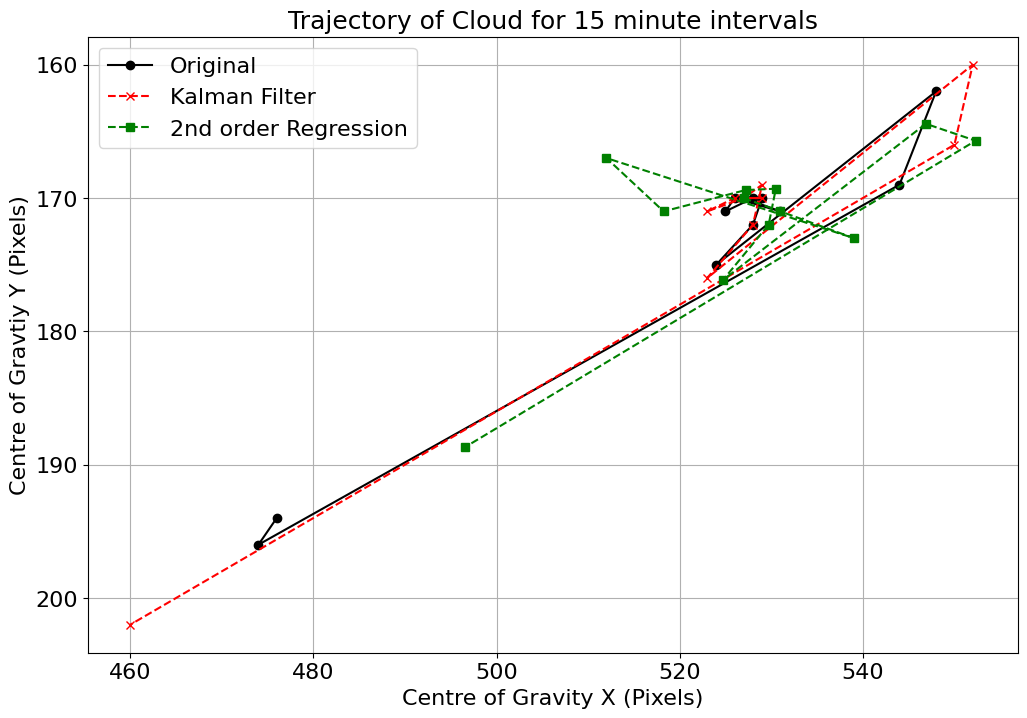

In [253]:
# Create a plot with an inverted y-axis
plt.figure(figsize=(12, 8))

# Original trajectory
plt.plot(x_coords, y_coords, marker='o', color='black', label='Original')

# Kalman filter predictions
plt.plot(predicted_x_kf, predicted_y_kf, marker='x', color='r', linestyle='--', label='Kalman Filter')

# Polynomial regression predictions
plt.plot(predicted_x_poly, predicted_y_poly, marker='s', color='g', linestyle='--', label='2nd order Regression')

# Invert the y-axis
plt.gca().invert_yaxis()

# Add labels and title
plt.xticks(fontsize=16)  # Set font size for x-axis ticks
plt.yticks(fontsize=16)  # Set font size for y-axis ticks
plt.xlabel('Centre of Gravity X (Pixels)',fontsize=16)
plt.ylabel('Centre of Gravtiy Y (Pixels)', fontsize=16)
plt.title(f'Trajectory of Cloud for 15 minute intervals',fontsize=18)
plt.legend(prop={'size': 16})
plt.grid()

plt.show()

In [256]:
df['Percent Change'] = filtered_df['Mask Area'].pct_change() * 100

In [257]:
df

,Track ID,Frame,Center X,Center Y,Mask Area,Percent Change
0,82,1,106,726,7530,NaN
1,82,2,106,726,7492,0.612840
2,82,3,79,825,3007,-1.617386
3,82,4,77,825,2986,-0.565023
4,24,1,1440,739,33614,-1.828623
5,24,2,1448,735,33820,-0.233990
6,24,3,1451,734,33273,-2.888532
7,24,4,1462,738,33085,-3.543282
8,24,5,1471,737,32480,-4.816657
9,24,6,1473,736,32404,-47.028486


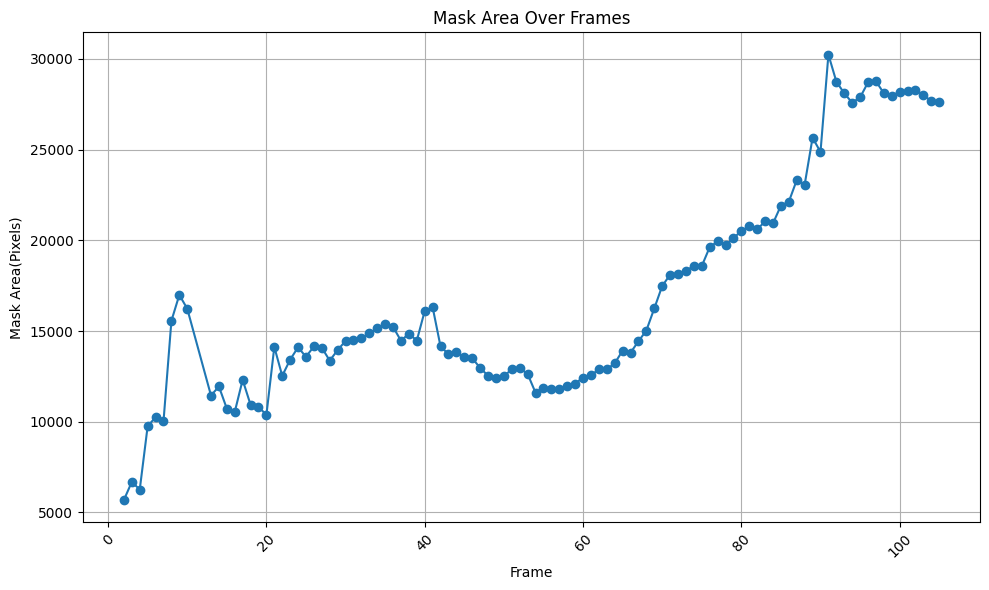

In [296]:
highlight_start = 0
highlight_end = 22

highlight_start1= 87
highlight_start2 = 93

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Frame'], filtered_df['Mask Area'], marker='o', linestyle='-')
#plt.axvspan(highlight_start, highlight_end, color='lightcoral', alpha=0.5)
#plt.axvspan(highlight_start1, highlight_start2, color='lightcoral', alpha=0.5)
plt.title('Mask Area Over Frames')
plt.xlabel('Frame')
plt.ylabel('Mask Area(Pixels)')
plt.xticks(rotation=45)  
plt.grid()
plt.tight_layout()
plt.show()